# Tarea 3 - Data Science

### **INF3831 - Bases de Datos**
---

Durante esta tarea trabajaremos con los datos del sistema nacional de información municipal del gobierno de Chile. La idea es hacer un análisis de datos para ver cómo se relacionan ciertos atributos de los municipios (como por ejemplo, número de centros culturales o gasto total en educación) con los puntajes PSU en establecimientos municipales.

## Parte I - Cargar datos a SQLite
---

Tienes acceso a las siguientes fuentes de datos:

1. Un archivo csv llamado `municipios.csv` con las siguientes columnas: 

    - CODIGO: el identificador de cada municipio.
    - MUNICIPIO: su nombre.
    
    
2. Un archivo csv llamado `datos_municipales_caracterizacion.csv` con las siguientes columnas:

    - CODIGO: código del municipio.
    - ISC: (KMS²) Superficie Comunal (km2).
    - ICAR004: (N°) Población Comunal, Estimada por el INE.
    
     
3. Una archivo csv llamado `datos_municipales_sociales.csv`, que contiene las siguientes columnas:

    - CODIGO: código del municipio.
    - ISOC001: (%) Indice de Pobreza CASEN (Última Encuesta Vigente).
    - LPCASEN: (%) Porcentaje de Población en Condiciones de Pobreza, según CASEN.
    - MSUFO: (N°) Subsidios Familiares (SUF) Otorgados en la comuna.
    - MPIE: (N°) Personas Inscritas en la Municipalidad en Busca de Empleo.
    - MCCULT: (N°) N° de Centros Culturales.
    
**Importante:** Nunca grabes un .csv desde excel, porque excel puede cambiar la codificación de esos archivos. En caso de problemas, siempre puedes volver a bajar el .csv desde la página del curso.


In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
conn = sqlite3.connect('municipios.db')
conn.text_factory = lambda x: str(x, 'utf-8')
curr = conn.cursor()

### T1 [1 pto] - Cargar datos

Tu primera misión es cargar estos datos a una base de datos SQL. Para esto, tienes dos opciones:

- Importar los datos del csv a la base de datos utilizando Python. Una forma de hacer esto es la propuesta en [el siguente link](https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python) o
- Importar los datos del csv al .db directamente con SQLite3 (esta opción requiere que instales SQLite3 en tu computador).

Tendrás que generar las siguientes tablas:

- `municipios(codigo, municipio)`: que asigna a cada municipio en Chile un identificador y su nombre.
- `datos_sociales(codigo, ISOC001, LPCASEN, MSUFO, MPIE, MCCULT)`: que asigna a cada municipio información relacionada con aspectos sociales.
- `caracteristicas_municipio(codigo, ISC, ICAR004)`: que indica las características de población y territoriales de cada municipio.


In [2]:
curr.execute("CREATE TABLE municipios (codigo int PRIMARY KEY, municipio varchar(30));")
df = pd.read_csv('./municipios.csv', sep=';', index_col=['CODIGO'])
curr.executemany("INSERT INTO municipios VALUES (?, ?);", df.itertuples())

conn.commit()

In [3]:
curr.execute(
"""CREATE TABLE datos_municipales_caracterizacion ( \
    codigo int PRIMARY KEY, \
    isc int, \
    icar int, \
    FOREIGN KEY(codigo) REFERENCES municipios(codigo) ON DELETE CASCADE);"""
)
df = pd.read_csv('./datos_municipales_caracterizacion.csv', sep=';', index_col=['CODIGO'])
curr.executemany("INSERT INTO datos_municipales_caracterizacion VALUES (?, ?, ?);", df.itertuples())

conn.commit()

In [4]:
curr.execute("""CREATE TABLE datos_sociales ( \
    codigo int PRIMARY KEY, \
    isoc int, \
    lpcasen float, \
    msufo int, \
    mpie int, \
    mccult int, \
    FOREIGN KEY(codigo) REFERENCES municipios(codigo) ON DELETE CASCADE);""")
df = pd.read_csv('./datos_municipales_sociales.csv', sep=';', index_col=['CODIGO'])
curr.executemany("INSERT INTO datos_sociales VALUES (?, ?, ?, ?, ?, ?);", df.itertuples())

conn.commit()

### T2 [0.5 ptos] - Establecer valores nulos

Existen comunas que no tienen información sobre ciertos atributos, por lo que tu deber es establecer estos valores como nulos en la base de datos. Para esto, puedes utilizar el siguiente comando:

```sql
UPDATE table_name SET attribute = NULL WHERE codición;
```

Como hint, en la tabla `caracteristicas_municipios` tendrás que setear como nulos los valores de `ISC` que sean igual 'Sin dato oficial'. Para el caso de `datos_sociales` tendrás que setear como nulos los valores de `MSUFO`, `MPIE` y `MCCULT` que sean igual a 'No Recepcionado'.

In [5]:
curr.execute("UPDATE datos_municipales_caracterizacion SET isc = NULL WHERE isc = 'Sin dato oficial'")
conn.commit()
curr.execute("UPDATE datos_sociales SET msufo = NULL WHERE msufo = 'No Recepcionado'")
conn.commit()
curr.execute("UPDATE datos_sociales SET mpie = NULL WHERE mpie = 'No Recepcionado'")
conn.commit()
curr.execute("UPDATE datos_sociales SET mccult = NULL WHERE mccult = 'No Recepcionado'")
conn.commit()

## Parte II - Análisis de datos
---

Ahora, además de contar con la base de datos que creaste en la parte anterior, tienes acceso al archivo `datos_municipales_educacion.csv` que tiene las siguientes columnas:

- CODIGO: código del municipio
- IEDU005: (%) Porcentaje de Asistencia Escolar Comunal
- IEDU011: (%) Porcentaje de Puntajes PSU Igual o Superior a 450 Puntos en Establecimientos Municipales de Educación
- IEDU018: (M\$) Subvención de Escolaridad (del Mineduc)
- IEDU025: (M\$) Gastos Educación (Gasto Total Devengado)
- IEDU035: (PERS) Número de Alumnos por Docente de Aula (Fuente: MINEDUC)

### T3 [0.5 ptos] - Crear dataframes

Crea los dataframes correspondientes para guardar la información:
- En el caso de la información que viene de la base de datos, tendrás que ejecutar las consultas correspondientes para crear los dataframes. 
- En el caso del csv con datos de educación, tendrás que cargarlos directamente con pandas. Una vez creado este dataframe,  tendrás que reemplazar los valores de 'No Recepcionado' y de 'Sin Servicio' a `np.nan`.

In [6]:
curr.execute("SELECT * FROM municipios;")
mdf = pd.DataFrame(curr.fetchall())
mdf = mdf.rename(columns={0: 'codigo', 1:'municipios'})
mdf

,codigo,municipios
0,1101,IQUIQUE
1,1107,ALTO HOSPICIO
2,1401,POZO ALMONTE
3,1402,CAMIÑA
4,1403,COLCHANE
...,...,...
340,16301,SAN CARLOS
341,16302,COIHUECO
342,16303,ÑIQUÉN
343,16304,SAN FABIÁN


In [7]:
curr.execute("SELECT * FROM datos_municipales_caracterizacion;")
cdf = pd.DataFrame(curr.fetchall())
cdf = cdf.rename(columns={0: 'codigo', 1:'isc', 2: 'icar'})
cdf

,codigo,isc,icar
0,1101,2262.0,216514
1,1107,573.0,124150
2,1401,13766.0,16683
3,1402,2200.0,1345
4,1403,4016.0,1556
...,...,...,...
340,16301,874.0,55935
341,16302,1777.0,28147
342,16303,493.0,11556
343,16304,1568.0,4607


In [8]:
curr.execute("SELECT * FROM datos_sociales;")
sdf = pd.DataFrame(curr.fetchall())
sdf = sdf.rename(columns={0: 'codigo', 1: 'isoc',
    2: 'lpcasen', 3: 'msufo', 4: 'mpie', 5: 'mccult'
})
sdf

,codigo,isoc,lpcasen,msufo,mpie,mccult
0,1101,"4,38",4.0,3899.0,5049.0,438.0
1,1107,"7,76",8.0,7382.0,8307.0,63.0
2,1401,"10,88",11.0,NaN,NaN,NaN
3,1402,"26,45",26.0,148.0,0.0,1.0
4,1403,"13,95",14.0,NaN,NaN,NaN
...,...,...,...,...,...,...
340,16301,"13,8",14.0,11371.0,1818.0,86.0
341,16302,"22,03",22.0,1856.0,1967.0,0.0
342,16303,"19,94",20.0,870.0,347.0,5.0
343,16304,"13,77",14.0,1132.0,303.0,4.0


In [9]:
edf = pd.read_csv('./datos_municipales_educacion.csv', sep=';')
edf.replace(to_replace=['No Recepcionado', 'Sin Servicio'], value=np.nan, inplace=True)
edf = edf.rename(columns={'CODIGO': 'codigo'})
edf

,codigo,IEDU005,IEDU011,IEDU018,IEDU025,IEDU035
0,1101,"79,9","31,74",14994697,36304957,"20,11"
1,1107,"81,92","60,76",4293683,6218158,"20,13"
2,1401,"85,12","27,04",6609770,9358336,"22,34"
3,1402,"91,56","12,5",633380,1744612,"11,84"
4,1403,"82,94",20,415662,1130047,"8,1"
...,...,...,...,...,...,...
340,16301,"90,82","39,74",7670037,15602246,"11,46"
341,16302,"91,44","48,48",4398201,6585446,"10,9"
342,16303,"88,21","34,09",3492336,6132479,"10,37"
343,16304,"92,75","57,5",1512666,3086471,"12,47"


In [10]:
df = pd.merge(cdf, edf, on='codigo')
df = pd.merge(df, sdf, on='codigo')

def str_map(x):
    try:
        return float(x.replace(',', '.'))
    except:
        return x

df = df.applymap(str_map)
df.describe()

,codigo,isc,icar,IEDU005,IEDU011,IEDU018,IEDU025,IEDU035,isoc,lpcasen,msufo,mpie,mccult
count,345.000000,335.000000,345.000000,345.000000,327.000000,3.330000e+02,3.340000e+02,345.000000,345.000000,345.000000,307.000000,311.000000,313.000000
mean,9025.817391,1988.352239,55382.855072,83.841855,41.917431,5.321525e+06,1.035719e+07,14.688464,12.711246,12.710145,2449.576547,1630.974277,28.220447
std,3819.867435,4597.480286,87008.227899,17.595292,15.837669,6.034648e+06,1.183492e+07,4.541622,7.526008,7.514137,3348.136903,2609.344210,72.669514
min,1101.000000,7.000000,213.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000
25%,6109.000000,247.000000,9825.000000,84.440000,32.280000,1.949612e+06,3.658399e+06,13.160000,7.270000,7.000000,562.500000,417.500000,1.000000
50%,8313.000000,618.000000,19688.000000,87.830000,42.310000,3.299841e+06,6.320581e+06,14.830000,11.420000,11.000000,1320.000000,870.000000,5.000000
75%,13103.000000,1517.000000,55761.000000,89.660000,50.905000,6.047584e+06,1.212908e+07,16.890000,16.660000,17.000000,2988.000000,1708.000000,23.000000
max,16305.000000,49924.000000,629743.000000,96.630000,93.420000,3.407406e+07,9.491681e+07,27.660000,41.600000,42.000000,30537.000000,28189.000000,756.000000


### T4 [1.5 ptos] - Análisis centro culturales por km2 vs puntajes PSU 

Crea un gráfico de puntos para visualizar la correlación entre la cantidad de centros culturales del municipio por km2 y el porcentaje de puntajes PSU igual o sobre los 450 puntos en establecimientos municipales. Luego calcula la correlación y establece alguna conclusión al respecto. 

Ojo que primero tendrás que limpiar los datos con los que vas a trabajar: no consideres los datos nulos, aunque eso signifique dejar algunas comunas fuera del análisis. Procura eliminar esos valores solo para este análisis puntual, ya que para los siguientes, puede que esas comunas sí tengan la información que necesitas. Por ejemplo, en este análisis estarás trabajando con los atributos ISC, MMCULT y IEDU011, entonces puedes dejar fuera a las comunas que tengan alguno de estos atributos nulos, pero no puedes dejar fuera comunas que tengan LPCASEN con valores nulos porque simplemente no lo estarás utilizando. Por lo mismo, las comunas que elimines tampoco pueden ser eliminadas definitivamente de tus dataframes, ya que en análisis posteriores, puede que esas mismas comunas no tengan los atributos que utilizarás con valores nulos. 

También tendrás que tener cuidado con los tipos de datos (int, string).

**HINT: recuerda que se pide analizar la cantidad de centros culturales por km2 por lo que tendrás que dividir ambos valores.**

In [11]:
temp_df = df[['IEDU011', 'mccult', 'isc']]
temp_df = temp_df.dropna()
temp_df = temp_df[temp_df['isc'] > 0]
temp_df.describe()

,IEDU011,mccult,isc
count,291.000000,291.000000,291.000000
mean,42.064227,30.082474,1685.233677
std,15.863113,75.016964,4318.103174
min,0.000000,0.000000,7.000000
25%,32.280000,1.000000,234.500000
50%,42.310000,6.000000,583.000000
75%,50.955000,24.500000,1353.000000
max,93.420000,756.000000,49924.000000


<Axes: xlabel='mccult_km2', ylabel='IEDU011'>

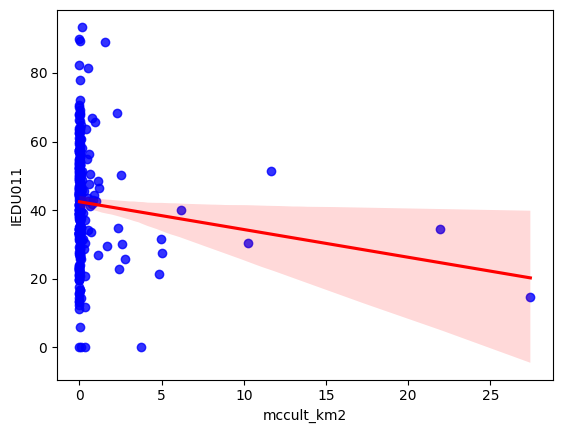

In [12]:
temp_df['mccult_km2'] = temp_df['mccult'] / temp_df['isc'] 

sns.regplot(x = 'mccult_km2', y='IEDU011', data=temp_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

In [13]:
np.corrcoef(temp_df['mccult_km2'], temp_df['IEDU011'])[0, 1]

-0.11934962532938655

No se observa una correlación determinante, en principio el porcentaje de las notas en establecimientos municipales no depende de la cantidad de centros culturales del mismo  

### T5 [1.5 ptos] - Análisis gasto en educación por habitante vs puntajes PSU 

Crea un gráfico de puntos para visualizar la correlación entre el gasto en educación por habitante de la comuna y el porcentaje de puntajes PSU igual o sobre los 450 puntos en establecimientos municipales. Luego calcula la correlación y establece alguna conclusión al respecto. 

Al igual que en la pregunta anterior, tendrás que limpiar los datos con los que vas a trabajar, siguiendo la misma regla.

**HINT: recuerda que se pide analizar el gasto en edicación por habitante, por lo que tendrás que dividir ambos valores.**

In [14]:
temp_df = df[['IEDU011', 'IEDU025', 'icar']]
temp_df = temp_df.dropna()
temp_df.describe()

,IEDU011,IEDU025,icar
count,316.000000,3.160000e+02,316.000000
mean,42.143070,1.087034e+07,58159.645570
std,16.017548,1.196047e+07,88990.884384
min,0.000000,0.000000e+00,1010.000000
25%,33.010000,4.111050e+06,10709.750000
50%,42.680000,6.607372e+06,20942.000000
75%,51.320000,1.271571e+07,58427.500000
max,93.420000,9.491681e+07,629743.000000


<Axes: xlabel='money_person', ylabel='IEDU011'>

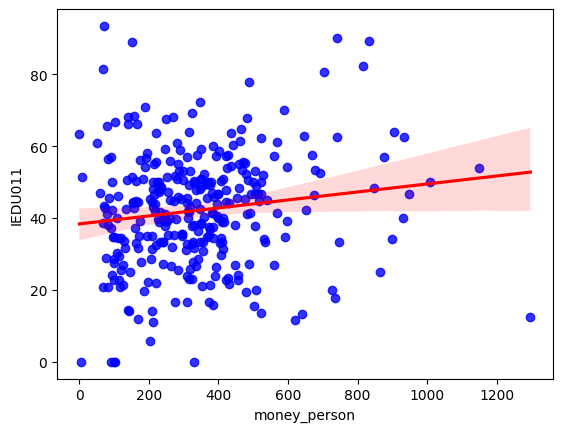

In [15]:
temp_df['money_person'] = temp_df['IEDU025'] / temp_df['icar'] 

sns.regplot(x = 'money_person', y='IEDU011', data=temp_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

In [16]:
np.corrcoef(temp_df['money_person'], temp_df['IEDU011'])[0, 1]

0.14020947915404042

### T6 [1 pto] - Análisis de atributo a elección vs puntajes PSU 

Elige alguna variable de las entregadas en los dataset que creas que puede estar relacionada con el porcentaje de puntajes PSU igual o superior a los 450 puntos en establecimientos municipales. Explica por qué crees que es relevante, crea un gráfico de puntos para visualizar la correlación entre ambas variables, calcula la correlación y establece alguna conclusión. Puede que tengas que limpiar los datos antes de trabajar al igual que en los apartados anteriores. Puedes dejar fuera municipios que tengan variables con valores nulos, siempre y cuando esas variables sean parte del análisis.

La cantidad de Subvención de Escolaridad en el municipio debe influir en los puntajes PSU, pues dichas subvenciones en principio se traducen en becas para talentos y personas interesadas en estudiar. Bajo este enfoque mientras más subvenciones hayan en el municipio más personas enfocada en sus estudios hay en este y los cuales debe alcanzar notas altas. 

In [17]:
temp_df = df[['IEDU011', 'IEDU018']]
temp_df = temp_df.dropna()
temp_df.describe()

,IEDU011,IEDU018
count,315.000000,3.150000e+02
mean,42.127460,5.593869e+06
std,16.040626,6.091561e+06
min,0.000000,0.000000e+00
25%,32.960000,2.073272e+06
50%,42.620000,3.462626e+06
75%,51.320000,6.408362e+06
max,93.420000,3.407406e+07


<Axes: xlabel='IEDU018', ylabel='IEDU011'>

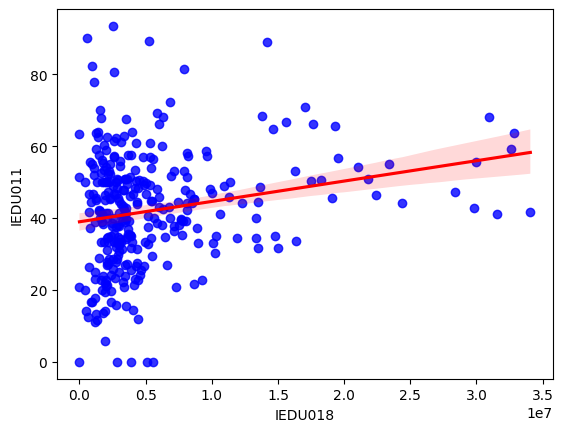

In [18]:
sns.regplot(x = 'IEDU018', y='IEDU011', data=temp_df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

In [19]:
np.corrcoef(temp_df['IEDU018'], temp_df['IEDU011'])[0, 1]

0.2149270408334755

En el gráfico que puede ver que en general los municipios con mayor cantidades de subvenciones presenta un buen porcentaje de puntajes altos. Aunque el reciproco no se cumple, el hecho de que el municipio no cuente con subvenciones no implica que los puntajes sean bajos, lo cual es lógico pues hay muchos otros factores que influyen en la variable objetivo. En resumen, el coeficiente de correlación es lógicamente bajo y el gráfico es muy ilustrativo.   

<Axes: >

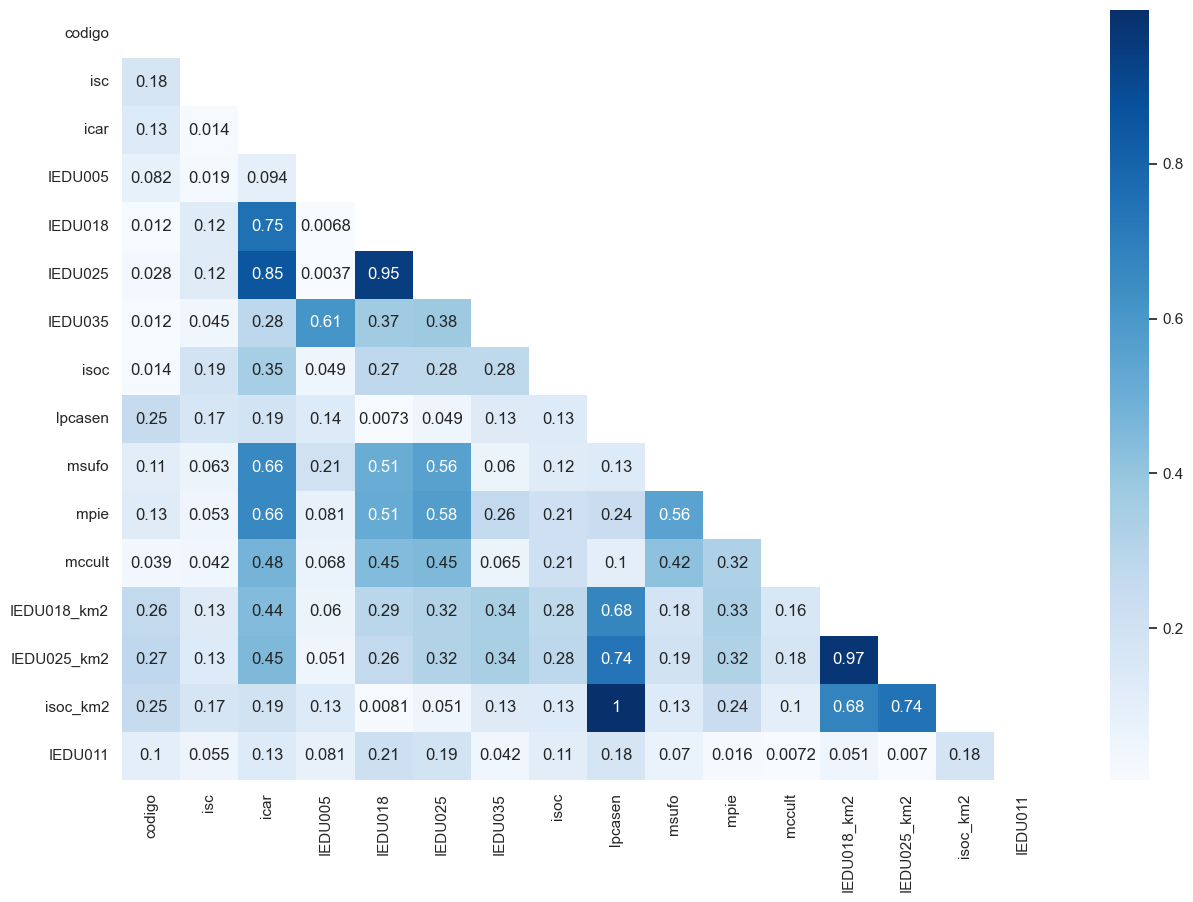

In [20]:
plt.figure(figsize=(15,10))

df['IEDU018_km2'] = df['IEDU018'] / df['isc'] 
df['IEDU025_km2'] = df['IEDU025'] / df['isc']
df['isoc_km2'] = df['isoc'] / df['isc']
df['lpcasen'] = df['lpcasen'] / df['isc']


df = df[df.columns.drop('IEDU011').tolist() + ['IEDU011']]

matrix = df.corr()
matrix.applymap(abs)

sns.set(style='white')
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True  # seleccionar la triangular superior

sns.heatmap(matrix.applymap(abs), annot=True, mask=mask, cmap='Blues')